In [1]:
import os
import sys

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
sys.path.append("../../deep-learning-dna")

In [4]:
import wandb

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import math
import string

import Set_Transformer 
from common.models import dnabert
from common import dna
from lmdbm import Lmdb
from common.data import DnaSequenceGenerator, DnaLabelType, DnaSampleGenerator, find_dbs
import wandb

import tf_utils as tfu

In [6]:
strategy = tfu.devices.select_gpu(0, use_dynamic_memory=True)

---
# Load Data

In [7]:
#Import pretrained model
api = wandb.Api()
model_path = api.artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-8dim:latest").download()
pretrained_model = dnabert.DnaBertModel.load(model_path)
pretrained_model.load_weights(model_path + "/model.h5")
pretrained_model

In [8]:
#Load datafiles
dataset_path = api.artifact("sirdavidludwig/nachusa-dna/dnasamples-complete:latest").download('/data/dna_samples:v1')
samples = find_dbs(dataset_path + '/train')
samples[13]

wandb: Downloading large artifact dnasamples-complete:latest, 4079.09MB. 420 files... Done. 0:0:0.1


'/data/dna_samples:v1/train/WS-CCW-Jul2015_S82_L001_R1_001.db'

---
# Create Dataset

In [9]:
#Generate batches
split_ratios = [0.8, 0.2]
subsample_length = 1000
sequence_length = 150
kmer = 3
batch_size = [20,5]
batches_per_epoch = 20
augument = True
labels = DnaLabelType.SampleIds
seed = 0
rng = np.random.default_rng(seed)
random_samples = samples.copy()

In [10]:
rng.shuffle(random_samples)

In [11]:
trimmed_samples, (train_dataset, val_dataset) = DnaSampleGenerator.split(samples=random_samples[0:50], split_ratios=split_ratios, subsample_length=subsample_length, sequence_length=sequence_length,kmer=kmer,batch_size=batch_size,batches_per_epoch=batches_per_epoch,augment=augument,labels=labels, rng=rng)

Sample '/data/dna_samples:v1/train/Wes7-PCRblank1_S8_L001_R1_001.db' does not contain enough sequences. This sample will be ignored.
Sample '/data/dna_samples:v1/train/Wes7-PCRblank1_S8_L001_R1_001.db' does not contain enough sequences. This sample will be ignored.


In [12]:
random_samples[0:50]

['/data/dna_samples:v1/train/WS-CCE-Apr2016_S6_L001_R1_001.db',
 '/data/dna_samples:v1/train/Wes52-10-TC_S53_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-WH-Jul2016_S46_L001_R1_001.db',
 '/data/dna_samples:v1/train/Wes41-10-HN_S42_L001_R1_001.db',
 '/data/dna_samples:v1/train/Wesley026-Ag-072820_S165_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-MU-Apr2016_S84_L001_R1_001.db',
 '/data/dna_samples:v1/train/Wes5-5-CCE_S6_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-MR-Apr2016_S13_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-MU-Sep2015_S43_L001_R1_001.db',
 '/data/dna_samples:v1/train/Wesley012-HN-051120_S151_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-HPN-Sep2015_S91_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-TCR-Sep2015_S52_L001_R1_001.db',
 '/data/dna_samples:v1/train/Wes26-8-AG_S27_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-SB-Jul2016_S22_L001_R1_001.db',
 '/data/dna_samples:v1/train/Wes25-8-MU_S26_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-SB-Oct

In [13]:
max_files = len(train_dataset.samples)
max_files

49

---
# Create Embeddings

In [14]:
#Create 8 dimensional embeddings
pretrained_encoder= dnabert.DnaBertEncoderModel(pretrained_model.base)
pretrained_encoder.trainable = False

In [15]:
class Create_Embeddings(keras.layers.Layer):
    def __init__(self, encoder):
        super(Create_Embeddings, self).__init__()
        self.encoder = encoder
        
    
    def subbatch_predict(self, model, batch, subbatch_size, concat=lambda old, new: tf.concat((old, new), axis=0)):
        def predict(i, result=None):
            n = i + subbatch_size
            pred = tf.stop_gradient(model(batch[i:n]))
            if result is None:
                return [n, pred]
            return [n, concat(result, pred)]
        i, result = predict(0)
        batch_size = tf.shape(batch)[0]
        i, result = tf.while_loop(
            cond=lambda i, _: i < batch_size,
            body=predict,
            loop_vars=[i, result],
            parallel_iterations=1)

        return result
    
    def modify_data_for_input(self, data):
        batch_size = tf.shape(data)[0]
        subsample_size = tf.shape(data)[1]
        flat_data = tf.reshape(data, (batch_size*subsample_size, -1))
        encoded = self.subbatch_predict(self.encoder, flat_data, 128)
        return tf.reshape(encoded, (batch_size, subsample_size, -1))
    
    def call(self, data):
        return  self.modify_data_for_input(data)

---
# Set Transformer Class

In [16]:
class Set_Transformer_Model(keras.Model):
    def __init__(self, num_induce, embed_dim, num_heads, stack, use_layernorm, pre_layernorm, use_keras_mha, seq_len, encoder, output_shape):
        super(Set_Transformer_Model, self).__init__()
        
        self.embedding_layer = Create_Embeddings(encoder)
        self.linear_layer = keras.layers.Dense(embed_dim)
        
        self.isabs = []
        
        for i in range(stack):
            self.isabs.append(Set_Transformer.SetAttentionBlock(embed_dim=embed_dim,num_heads=num_heads,use_layernorm=use_layernorm,pre_layernorm=pre_layernorm,use_keras_mha=use_keras_mha))
      
        self.pooling_layer = Set_Transformer.PoolingByMultiHeadAttention(num_seeds=1,embed_dim=embed_dim,num_heads=1,use_layernorm=use_layernorm,pre_layernorm=pre_layernorm,use_keras_mha=use_keras_mha,is_final_block=True)
    
        self.reshape_layer = keras.layers.Reshape((embed_dim,))
        
        self.output_layer = keras.layers.Dense(output_shape)
    
    def call(self, data):
        
            embeddings = self.embedding_layer(data)
            
            linear_transform = self.linear_layer(embeddings)
            
            attention = linear_transform
            
            for isab in self.isabs:
                attention = isab([attention, None])
                
            pooling = self.pooling_layer(attention)
        
            reshape = self.reshape_layer(pooling)
            
            output = self.output_layer(reshape)    
            
            return output

---
# Create Model

In [23]:
#Hyperparameters
num_induce = 48
embed_dim = 64
num_heads = 8
stack = 4
use_layernorm = True
pre_layernorm = True
use_keras_mha = True
seq_len = 148
encoder = pretrained_encoder
output_shape = max_files

In [24]:
Parameters = dict(
    num_induce = 48,
    embed_dim = 64,
    num_heads = 8,
    stack = 4,
    use_layernorm = True,
    pre_layernorm = True,
    use_keras_mha = True,
    seq_len = 148,
    output_shape = max_files)

In [25]:
run = wandb.init(project="Str", config=Parameters)

In [26]:
model = Set_Transformer_Model(num_induce, embed_dim, num_heads, stack, use_layernorm, pre_layernorm, use_keras_mha, seq_len, encoder, output_shape)
model.compile(optimizer=keras.optimizers.Adam(1e-3),loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = [keras.metrics.sparse_categorical_accuracy])

In [27]:
epochs = 10000

In [ ]:
history = model.fit(x=train_dataset, validation_data=val_dataset, epochs=epochs, verbose=1, callbacks=[wandb.keras.WandbCallback(save_weights_only=True)])

wandb: WARNING Unable to compute FLOPs for this model.


Epoch 1/10000
20/20 [==============================] - 119s 6s/step - loss: 3.9910 - sparse_categorical_accuracy: 0.0375 - val_loss: 3.6718 - val_sparse_categorical_accuracy: 0.0500 - _timestamp: 1658865182.0000 - _runtime: 127.0000
Epoch 2/10000
20/20 [==============================] - 111s 6s/step - loss: 3.5583 - sparse_categorical_accuracy: 0.0550 - val_loss: 3.4149 - val_sparse_categorical_accuracy: 0.0400 - _timestamp: 1658865293.0000 - _runtime: 238.0000
Epoch 3/10000
20/20 [==============================] - 110s 6s/step - loss: 3.3805 - sparse_categorical_accuracy: 0.0500 - val_loss: 3.4159 - val_sparse_categorical_accuracy: 0.0400 - _timestamp: 1658865404.0000 - _runtime: 349.0000
Epoch 4/10000
20/20 [==============================] - 112s 6s/step - loss: 3.3593 - sparse_categorical_accuracy: 0.0275 - val_loss: 3.3617 - val_sparse_categorical_accuracy: 0.0600 - _timestamp: 1658865516.0000 - _runtime: 461.0000
Epoch 5/10000
20/20 [==============================] - 112s 6s/step 

In [ ]:
run.finish()

In [ ]:
model.save_weights("./Saved_Models/Str_Run1.h5")

In [ ]:
model.evaluate(val_dataset)

In [ ]:
trimmed_samples[0:5]

NameError: name 'history' is not defined

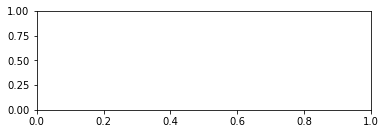

In [23]:
#Plot history and accuracy
plt.subplot(211)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show() 